# Human Short Promoter Classification with Genomic Pretraining

This notebook uses the weights from the language model trained in the previous notebook to initialize a classification model. This notebook uses the short promoters dataset. 

For more detail about the method and why pretraining is important, see the [E. coli 3 Bacterial Ensemble Pretraining](https://github.com/kheyer/Genomic-ULMFiT/blob/master/Bacteria/E.%20Coli/E.%20coli%203%20Bacterial%20Ensemble%20Pretraining.ipynb) notebook.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx

In [3]:
sys.path.append("../../..")
from utils import *

In [4]:
path = Path('F:/genome/human/')

# Classification

In [5]:
classification_df = pd.read_csv(path/'human_promoters_short.csv')

In [6]:
classification_df.head()

,Sequence,Promoter,set
0,CTGTGAGTGCATACACCCTAGGTTGGGTAGGTGACCAGAGGACCTT...,1,train
1,GGGTCCGGTCGGGCGCCGCGGGGCCGTAGTTTTCGGGTCGGCGGGC...,1,train
2,GGAGTTCACTTAAGCTCTCCACCTACCTTGCTATATCTCTCCTCCC...,1,train
3,GTGAGGCGCGCGCTTGCCTGGCTAGGGTCCCTGTGAAGGAATGGGA...,1,train
4,CCCTAGGTTCTGCTCCCGACAGGCCGTCGCGGGACCGGAGCCCTCG...,1,train


In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [8]:
voc = np.load(path/'human_vocab_5mer.npy')
model_vocab = GenomicVocab(voc)

In [9]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Promoter', bs=400)

In [12]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.6

In [13]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [14]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(1025, 400, padding_idx=0)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(1025, 400, padding_idx=0)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.24)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0

In [15]:
learn.load_encoder('human_genome_full_enc3')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-04


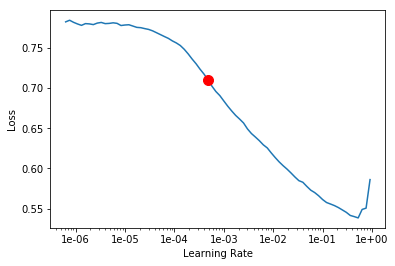

In [16]:
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(6, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.433338,0.393080,0.837648
2,0.413481,0.391833,0.835386
3,0.402680,0.375627,0.841417
4,0.393907,0.383141,0.842925
5,0.391255,0.366258,0.845941
6,0.385577,0.364404,0.845690


In [17]:
learn.freeze_to(-2)
learn.fit_one_cycle(6, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.376752,0.351588,0.852224
2,0.360894,0.335407,0.859764
3,0.341646,0.318500,0.864539
4,0.321643,0.321016,0.869565
5,0.300803,0.305563,0.870570
6,0.288646,0.301623,0.873838


In [18]:
learn.freeze_to(-3)
learn.fit_one_cycle(6, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.280351,0.295638,0.875848
2,0.281535,0.275184,0.882383
3,0.264113,0.260612,0.891179
4,0.237185,0.250380,0.900226
5,0.225379,0.247444,0.901231
6,0.214146,0.247147,0.900478


In [19]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.207917,0.246823,0.900980
2,0.208769,0.243141,0.901483
3,0.204198,0.243259,0.904750
4,0.200868,0.236795,0.908268
5,0.194795,0.240651,0.908520
6,0.188617,0.237078,0.908771
7,0.182721,0.234302,0.909274
8,0.179378,0.234030,0.911787
9,0.175987,0.240855,0.910028
10,0.177819,0.236624,0.912038


In [20]:
learn.fit_one_cycle(10, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.180863,0.242420,0.910279
2,0.184406,0.246791,0.910279
3,0.180756,0.273924,0.903493
4,0.167996,0.229371,0.915305
5,0.155852,0.224011,0.920583
6,0.139917,0.217714,0.922091
7,0.125179,0.216570,0.923850
8,0.111657,0.234065,0.924604
9,0.103331,0.235795,0.926363
10,0.099493,0.236965,0.925358


In [21]:
learn.fit_one_cycle(10, slice(5e-4/(2.6**4),5e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.098022,0.239176,0.925358
2,0.099476,0.241787,0.925107
3,0.099236,0.243264,0.924353
4,0.097088,0.234778,0.928123
5,0.094294,0.237496,0.925861
6,0.095166,0.231851,0.926866
7,0.091656,0.243208,0.923599
8,0.087546,0.234596,0.927871
9,0.088981,0.232373,0.927369
10,0.085498,0.243106,0.925107


In [ ]:
learn.save('human_short_human_pretrain')

In [22]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, test_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Promoter', bs=400)
learn.data = data_clas

In [23]:
get_scores(learn)

Accuracy: 0.922846975088968
False Positives: 0.013523131672597865
False Negatives: 0.06362989323843417
Recall: 0.8494442573256988
Precision: 0.9636988918609094
Specificity: 0.9765779092702169
MCC: 0.8439624411252946
